In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.models import model_ND

## 1 Segment

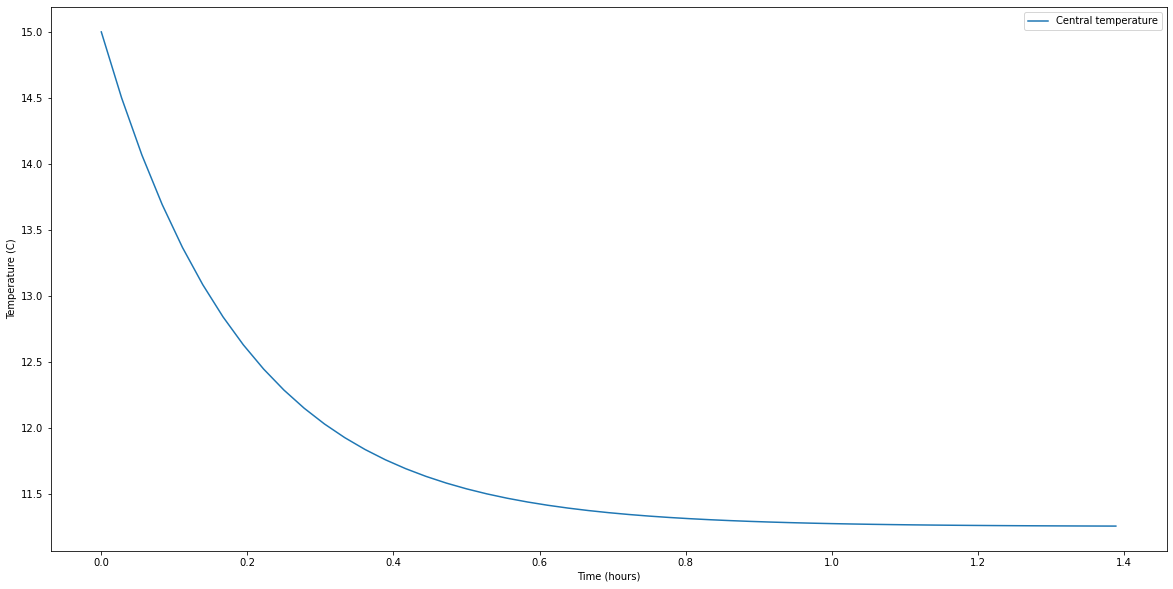

In [4]:
k = 6e5
c = 800.0
T = 15.0
T_out = 10
heatinput = 1000

# Initialise class with system parameters
sys_nd = model_ND(k, c, T, T_out, heatinput)

timestep = 60
iterations = 50

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 5e3, iterations+1)
Ts, Qs = sys_nd.run(times=times)
Ts = Ts.flatten()

In [5]:
def f(times, k_est, c_est, T_est):

    heatinput, T_out, iterations = [1000, 10, 50]
    Ts_est = [T_est]
    
    dt = np.diff(times)
    for i in range(iterations):
        net_heatflow = heatinput - c_est * (T_est - T_out)
        T_est += (net_heatflow / k_est) * dt[i]
        Ts_est.append(T_est)
        
    Ts_est = np.array(Ts_est)
    
    return Ts_est

In [6]:
from scipy.optimize import curve_fit, minimize

In [7]:
popt, pcov = curve_fit(f, times, Ts, p0=[5e5, 1000, 5])

In [8]:
print('Estimated parameters:\nk\t\t{:.2f}\nc\t\t{:.2f}\nT_initial\t{}'.format(*popt))

Estimated parameters:
k		600000.00
c		800.00
T_initial	15.0


We are able to recover the desired heat capacity, thermal conductivity and initial temperature even with pretty bad intial guesses. However, need to ensure intial guesses are at least on the right order of magnitude.

## 2 Segments

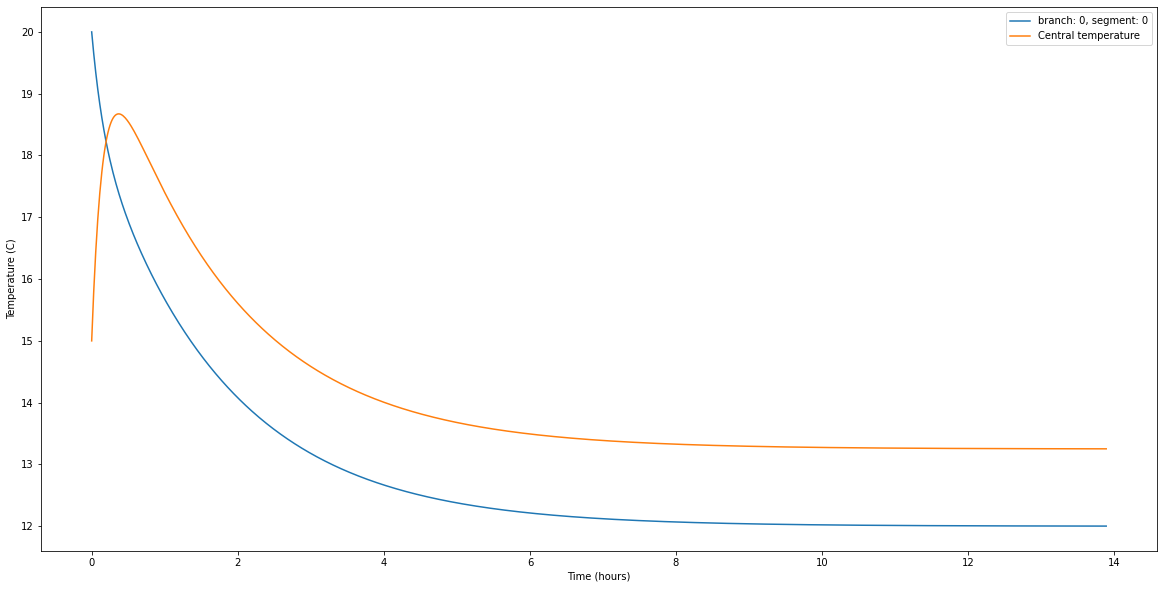

In [9]:
k = [6e5, 2.5e6]
c = [800.0, 500.0]
T = [15.0, 20.0]
true_params = np.array([*k, *c, *T])
T_out = 10
heatinput = 1000
iterations = 1000
# Initialise class with system parameters
sys_nd = model_ND(k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 5e4, iterations+1)
Ts_true, Qs = sys_nd.run(times=times)

In [10]:
def loss(params):
    
    # This loss function needs to be a lot faster as it will be called many times by scipy minimize
    
    T_out = 10
#     k_est, c_est, T_est = params
    k1, k2, c1, c2, T1, T2 = params
    
    k_est = np.array([k1,k2]).reshape(1,-1)
    c_est = np.array([c1,c2]).reshape(1,-1)
    T_est = np.array([T1,T2]).reshape(1,-1)
    
    times = np.linspace(0, 5e4, iterations+1)
    T_out = np.array(T_out).reshape(-1,1)
    Ts = np.empty(shape=(len(times), 1, 2))
    Ts[0] = T_est
    Q_in = 1000
    
    dtimes = np.diff(times)
    for i in range(len(times)-1):
        
        heat_flux = np.diff(np.hstack((T_est,T_out)))*c_est
        net_heat_flux = np.diff(heat_flux)
        
        # update non central nodes
        T_est[:, 1:] += ( net_heat_flux / k_est[:,1:] ) * dtimes[i]
        
        # update central node
        T_est[:, 0] += ( (heat_flux[:,0] + Q_in) / k_est[:,0] ).sum() * dtimes[i]
    
        Ts[i+1] = T_est

    Ts = np.transpose(Ts,axes=(1,2,0)) # New shape has (n_branches, n_segments, n_iterations)
    
    return np.mean((Ts_true - Ts) ** 2)

In [11]:
k = [6e5, 1e6]
c = [1000.0, 500.0]
T = [15.0, 15.0]
params = np.array([*k, *c, *T])
mse = loss(params)

In [12]:
mse

1.7379984373977788

Now we need to fit both functions

In [13]:
result = minimize(loss, x0=params)

In [14]:
result

      fun: 0.1511685832150911
 hess_inv: array([[ 9.48412068e+00,  8.80050007e+00, -2.73277400e+03,
         2.85891991e+02,  3.31489083e+00, -5.58198080e-01],
       [ 8.80050007e+00,  1.01286830e+01, -2.83470288e+03,
         2.96298336e+02,  3.44285003e+00, -5.85971444e-01],
       [-2.73277400e+03, -2.83470288e+03,  8.80324280e+05,
        -9.10938510e+04, -1.06190815e+03,  1.98725148e+02],
       [ 2.85891991e+02,  2.96298336e+02, -9.10938510e+04,
         2.13124847e+04,  1.89421771e+02,  1.83953077e+02],
       [ 3.31489083e+00,  3.44285003e+00, -1.06190815e+03,
         1.89421771e+02,  1.75724830e+02, -1.14182640e+02],
       [-5.58198080e-01, -5.85971444e-01,  1.98725148e+02,
         1.83953077e+02, -1.14182640e+02,  1.12027657e+02]])
      jac: array([-2.51457095e-07, -3.27825546e-07, -5.21540642e-08, -3.53902578e-08,
       -1.97999179e-06, -2.72318721e-06])
  message: 'Optimization terminated successfully.'
     nfev: 399
      nit: 52
     njev: 57
   status: 0
  success

In [15]:
frac_error = abs((result['x'] - true_params)/true_params * 100)

In [16]:
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))





Percentage error:
k1:		0.00%		k2:		60.00%
c1:		8.82%		c2:		16.47%
T1_initial:	5.58%		T2_initial:	15.73%


Is the jacobian the error on each parameter? Need to investigate.

In [17]:
result['jac']

array([-2.51457095e-07, -3.27825546e-07, -5.21540642e-08, -3.53902578e-08,
       -1.97999179e-06, -2.72318721e-06])